In [52]:
# Wavefunction generation
from pyscf import mcscf, fci, lib 
from pyscf import gto, scf, tools, dft
import api as pyq 
import importlib
import os
import h5py
import pandas as pd
import pdb
import pyscf
import numpy as np
import pyqmc
import scipy
import matplotlib.pyplot as plt
from pyscf.scf.hf import dump_scf_summary
from concurrent.futures import ProcessPoolExecutor
from pyscf.scf.chkfile import dump_scf
print(pyq.__file__)
print(pyscf.__file__)

/Users/ksu/Documents/GitHub/pyqmc2/pyqmc/pyqmc/api.py
/Users/ksu/Software/anaconda3/lib/python3.11/site-packages/pyscf/__init__.py


In [53]:
# H2 molecule
def run_scf(scf_checkfile):
    mol = gto.M(atom="H 0. 0. 0.;H 0. 0. 1.;", basis=f'ccecpccpvdz', unit='bohr')
    mf = scf.UHF(mol)
    mf.chkfile = scf_checkfile
    dm = mf.init_guess_by_atom()
    mf.kernel(dm)
    dump_scf(mf.mol, 'scf.hdf5', mf.energy_tot(), mf.mo_energy, mf.mo_coeff, mf.mo_occ)
    return mf

def run_lda_be(scf_checkfile):
    print("Be atom neutral LDA spin=2")
    mol = gto.M(atom="Be 0. 0. 0.", spin=0,basis=f'ccpvdz', unit='bohr')
    print("HF")
    mf = scf.UHF(mol)
    mf.kernel()
    print("LDA")        
    mf = dft.UKS(mol)
    # mf.verbose=6
    mf.chkfile = scf_checkfile
    dm = mf.init_guess_by_atom()
    mf.kernel(dm, xc='LDA')
    return mf

def run_lda_li(scf_checkfile):
    print("Li atom neutral LDA spin=1")
    mol = gto.M(atom="Li 0. 0. 0.",basis=f'ccpvtz', spin=1, unit='bohr')
    print("HF")
    mf = scf.UHF(mol)
    mf.kernel()
    print("LDA")    
    mf = dft.UKS(mol)
    # mf.verbose=6
    mf.chkfile = scf_checkfile
    dm = mf.init_guess_by_atom()
    mf.kernel(dm, xc='LDA')
    return mf

def run_lda_he(scf_checkfile):
    print("He atom neutral LDA spin=0")
    # mol = gto.M(atom="He 0. 0. 0.", basis="ccECP_cc-pVDZ", ecp="ccecp", unit='bohr')
    mol = gto.M(atom="He 0. 0. 0.", basis="ccpvdz", unit='bohr')    
    print("HF")
    mf = scf.UHF(mol)
    mf.kernel()
    print("LDA")    
    mf = dft.UKS(mol)
    # mf.verbose=6
    mf.chkfile = scf_checkfile
    dm = mf.init_guess_by_atom()
    mf.kernel(dm, xc='LDA')
    return mf

def run_lda_h2(scf_checkfile):
    mol = gto.M(atom="H 0. 0. 0.; H 0. 0. 2", spin = 2, basis=f'ccecpccpvdz', unit='bohr')
    mf = dft.UKS(mol)
    # mf.verbose=6
    mf.chkfile = scf_checkfile
    dm = mf.init_guess_by_atom()
    mf.xc='LDA, VWN'
    mf.kernel()    
    # mf.kernel(dm, xc='LDA,VWN')
    return mf

def run_lda(scf_checkfile):
    mol = gto.M(atom="H 0. 0. 0.", spin=1,basis=f'ccecpccpvdz', unit='bohr')
    mf = dft.UKS(mol)
    # mf.verbose=6
    mf.chkfile = scf_checkfile
    dm = mf.init_guess_by_atom()
    mf.kernel(dm, xc='LDA')
    return mf
    
def run_casscf(scf_checkfile, ci_checkfile):
    cell, mf = pyq.recover_pyscf(scf_checkfile, cancel_outputs=False)
    mc = mcscf.CASSCF(mf,2,2)
    mc.chkfile = ci_checkfile
    mc.kernel()
    with h5py.File(mc.chkfile, "a") as f:
        print("Available output from CASSCF:", f["mcscf"].keys())
        f["mcscf/nelecas"] = list(mc.nelecas)
        f["mcscf/ci"] = mc.ci
    return mc

def run_casci(scf_chkfile):
    ci_chkfile = scf_chkfile.split('.hdf5')[0]+'-ci.hdf5'
    cell, mf = pyq.recover_pyscf(scf_chkfile, cancel_outputs=False)
    # ncas: orbitals
    # nelecas: electrons
    ncas = 2
    nelecas = mf.nelec
    mc = mcscf.CASCI(mf, ncas, nelecas)
    mc.fcisolver.nroots = 4
    for fname in [ci_chkfile]:
        if os.path.isfile(fname):
            os.remove(fname)   
    mc.kernel()
    print(mc.__dict__.keys())
    with h5py.File(ci_chkfile, "a") as f:
        f.create_group("ci")
        f["ci/ncas"] = mc.ncas
        f["ci/nelecas"] = list(mc.nelecas)
        f["ci/fci"] = mc.ci
        f["ci/ci"] = mc.ci
        f["ci/mo_coeff"] = mc.mo_coeff
        print("Available output from CASCI:", f["ci"].keys())
    return ci_chkfile, mc

def make_wf_object(scf_checkfile, ci_checkfile):
    mol, mf, mc = pyq.recover_pyscf(scf_checkfile, ci_checkfile=ci_checkfile)
    wf, _ = pyq.generate_wf(mol, mf, mc=mc)
    return wf

def stat_qmc(etot, filename):
    block_sizes = np.linspace(2,len(etot[discard:])//16, 10, dtype=int)
    reblocks = [len(etot)//s for s in block_sizes]

    plt.figure()
    df = pd.DataFrame([pyq.read_mc_output(filename, warmup=discard, reblock=reblock) for reblock in reblocks])
    df['block_size'] = block_sizes
    plt.plot("block_size",'energytotal_err',data=df, marker='o')
    plt.xlabel("Block size")
    plt.ylabel("Estimated uncertainty (Ha)")

def reblock(e, discard, reblock_size):
    e = e[discard:]
    vals = pyqmc.reblock.reblock(e,int(len(e)/reblock_size))
    # import pdb
    # pdb.set_trace()
    
    e_m  = np.mean(vals, axis=0)
    e_d  = scipy.stats.sem(vals, axis=0)    
    return e, e_m, e_d

scf_checkfile = "scf.hdf5"
# mf = run_scf(scf_checkfile)
mf_lda = run_lda_he(scf_checkfile)

ci_checkfile, mc = run_casci(scf_checkfile)

He atom neutral LDA spin=0
HF
converged SCF energy = -2.85516047724274  <S^2> = 0  2S+1 = 1
LDA
converged SCF energy = -2.82670655418611  <S^2> = 4.4408921e-16  2S+1 = 1

WARN: Mulitple states found in CASCI solver. First state is used to compute the Fock matrix and natural orbitals in active space.

CASCI state   0  E = -2.87015742152925  E(CI) = -2.87015742152925  S^2 = 0.0000000
CASCI state   1  E = -1.40116327670131  E(CI) = -1.40116327670131  S^2 = 2.0000000
CASCI state   2  E = -0.950953194776060  E(CI) = -0.950953194776060  S^2 = 0.0000000
CASCI state   3  E = 0.604815912795335  E(CI) = 0.604815912795335  S^2 = 0.0000000
dict_keys(['mol', '_scf', 'verbose', 'stdout', 'max_memory', 'ncas', 'nelecas', '_ncore', 'fcisolver', 'frozen', 'extrasym', 'e_tot', 'e_cas', 'ci', 'mo_coeff', 'mo_energy', 'mo_occ', 'converged'])
Available output from CASCI: <KeysViewHDF5 ['ci', 'fci', 'mo_coeff', 'ncas', 'nelecas']>


In [54]:
# Multi determinant boson new gradient
import importlib, bosonrecipes, bosonslater, bosonwftools
modules = [importlib, bosonrecipes, bosonslater, bosonwftools]
for m in modules:
    importlib.reload(m)

import importlib, slater, pyscftools,recipes, wftools, mc
modules = [importlib, slater, pyscftools,recipes, wftools, mc]
for m in modules:
    importlib.reload(m)


# import pyqmc.pyscftools as pyscftools

nconfig = 323
multi = True
if multi:
    mol, mf, mcc = pyscftools.recover_pyscf(scf_checkfile, ci_checkfile = ci_checkfile)
    target_root = 0
    if not hasattr(mcc.ci, "shape") or len(mcc.ci.shape) == 3:
        mcc.ci = mcc.ci[target_root]
else:
    mol, mf = pyscftools.recover_pyscf(scf_checkfile)
    mcc = None
    
wfb, to_opt = bosonwftools.generate_boson_wf(
        mol, mf, mc=mcc, jastrow=None, jastrow_kws=None, slater_kws=None
        )

wfs, to_opt = wftools.generate_wf(
        mol, mf, mc=mcc, jastrow=None, jastrow_kws=None, slater_kws=None
        )


Number of determinants in the bosonic wavefunction= 4


In [55]:
wfs

In [56]:
wfb

In [57]:
nconfig = 100
mol, mf = pyscftools.recover_pyscf(scf_checkfile)
configs = mc.initial_guess(mol, nconfig)
signb, phib = wfb.recompute(configs)
signs, phis = wfs.recompute(configs)

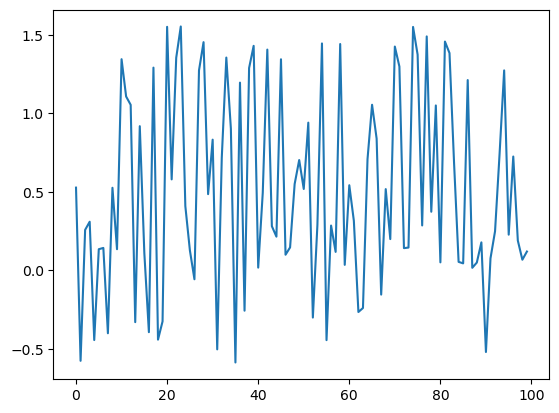

In [58]:
# Difference in values
plt.plot(phib-phis)

In [59]:
e=0
gradb, _, _ = wfb.gradient_value(e, configs.electron(e))
grads, _, _ = wfs.gradient_value(e, configs.electron(e))

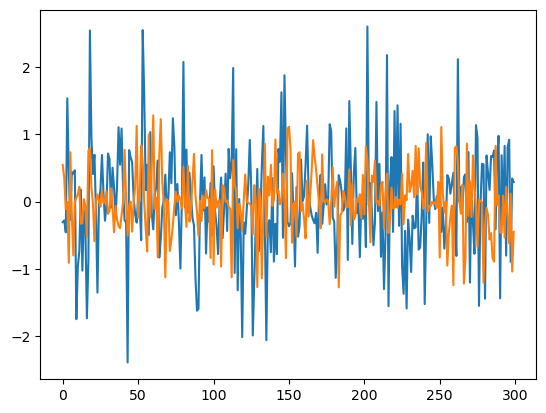

In [60]:
# Differnce in gradients
plt.plot(gradb.flatten())
plt.plot(gradb.flatten()-grads.flatten())

In [61]:
gradbr, _ = wfb.gradient_value_real(e, configs.electron(e))
gradbl, _, _ = wfb.gradient_value_log(e, configs.electron(e))

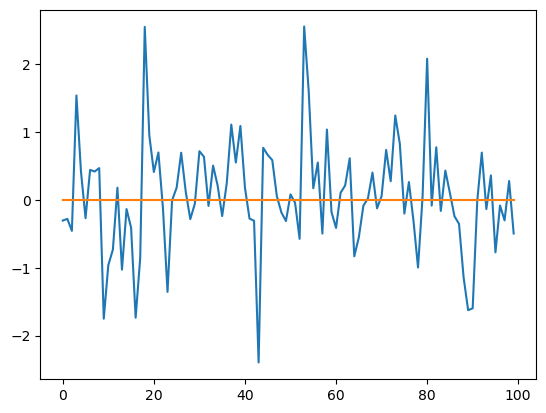

In [62]:
# check between the real and log gradients
idx = 0
plt.plot(gradbl[idx])
plt.plot(gradbl[idx]-gradbr[idx]/np.exp(phib))